Given two measures $f^+$ and $f^-$ with equal mass, the [Monge-Kantorovich Equations](https://www.intlpress.com/site/pub/files/_fulltext/journals/cdm/1997/1997/0001/CDM-1997-1997-0001-a002.pdf) reads as finding the Kantorovich Potential $u^*$ and
the Optimal Transport Densisity $\mu^*$ solving the following system of PDE
$$
\nabla \cdot ( \mu^*(x) \nabla u^*(x) )= f^{+}(x)-f^{-}(x) \\
|\nabla u^*(x)|\leq 1 \\
|\nabla u^*(x)|=1 \mbox{\ where \ } \mu^*(x)>0. \\
$$
This is the PDE-based formulation of the Optimal Transport Problem with cost equal to the Euclidean distance.

In this notebook we reproduce Test-Case-1
[FaccaDaneriCardinPutti2020](https://link.springer.com/article/10.1007/s10915-020-01170-8).
where the problem is settled in the square $[0,1]\times[0,1]\subset R^2$ with $f^+$ and $f^-$
given by
$$
f^+(x)=2 \ \mbox{on}\  [1/8,3/8]\times [1/4,3/4] \\
f^-(x)=2 \ \mbox{on}\  [5/8,7/8]\times [1/4,3/4] \\
$$
and zero elsewhere.

We show how to pass the input data (triangulationed grid, forcings terms) and the algorithm controls to the dmk solver. Copy this notebook, change the triangulation and the measures $f^+$ and $f^-$ to run your own experiments.

In [1]:
# 
# Loading stardard and dmk pyhton modules
#

# Standard tools
import sys
import numpy as np


# Import I/O for timedata
try:
    sys.path.append('../../../../../globals/python/timedata/')
    import timedata as td
except:
    print("Global repo non found")

# Import geometry tools
sys.path.append('../../../../../geometry/python/')
import meshtools as mt
sys.path.append('../../../preprocess/assembly/')
import example_grid

# Import dmk tools
sys.path.append('../../')
import dmk_p1p0 
sys.path.append('../../../../build/python/fortran_python_interface/')
from dmk import (Dmkcontrols,  # controls for dmk simulations)
                 Timefunctionals # information of time/algorithm evolution
                )
# Import plot tools
import matplotlib.pyplot as plt

/home/fh/test_abdullahi/dmk_solver/globals/python_timedata
/home/fh/test_abdullahi/dmk_solver/otp_solver/python/examples/FaccaDaneriCardinPutti2020_TestCase1
/home/fh/test_abdullahi/dmk_solver/otp_solver/preprocess/assembly
/home/fh/test_abdullahi/dmk_solver/build/python/fortran_python_interface


In [2]:
#
# Define mesh for spatial disctetization.
# Build the "coord" and "topol" numpy arrays describing coordinate and topology of the mesh.
#

# set mesh size 
ndiv=32
length=1.0/float(ndiv)
nref=0


# set grid example
flag_grid='rect_cnst'

# build grid using prebuild examples 
points, vertices, coord,topol,element_attributes = example_grid.example_grid(flag_grid,length)

3174


In [3]:
#
# We create piecewise constant rapresentations of $f,f^+,f-$ and $\mu^*$,
# evaluating the function on cell centroids.
#


# define source and sink functions, value of grid centroids
def source(coord):
    x=coord[0]; y=coord[1]
    if ((x >= 1.0/8.0) and (x<=3.0/8.0) and
        (y >= 1.0/4.0) and (y<=3.0/4.0) ) :
        fvalue=2.0
    else:
        fvalue=0.0
        
    return fvalue;

def sink(coord):
    x=coord[0]; y=coord[1]    
    if ((x >= 5.0/8.0) and (x<=7.0/8.0) and
        (y >= 1.0/4.0) and (y<=3.0/4.0) ) :
        fvalue=2.0
    else:
        fvalue=0.0       
    return fvalue;
# For this case there exists an explicit solution of the Monge-Kantorivich equations:
# The optimal transport density:
def optimal_transport_density(coord):
    x=coord[0]; y=coord[1];
    if ((x >= 1.0/8.0) and (x<=3.0/8.0) and
        (y >= 1.0/4.0) and (y<=3.0/4.0) ) :
        fvalue=(x-1.0/8.0)*2.0
    elif ((x >= 3.0/8.0) and (x<=5.0/8.0) and
          (y >= 1.0/4.0) and (y<=3.0/4.0) ) :
        fvalue=(3.0/8.0-1.0/8.0)*2.0 
    elif ((x >= 5.0/8.0) and (x<=7.0/8.0) and
          (y >= 1.0/4.0) and (y<=3.0/4.0) ) :
        fvalue=(7.0/8.0-x)*2.0
    else:
        fvalue=0.0
    return fvalue;
# exact wasserstein distance
exact_wass1=1.0/8.0


# and the Kantorovich potential
def kantorovich_potenial(coord):
    x=coord[0];        
    return -x;

# compute functions on cell centroids
ncell=len(topol)
bar_cell=mt.make_bar(coord,topol).transpose()
source_cell=np.zeros([ncell]); sink_cell=np.zeros([ncell]); opttdens_cell=np.zeros([ncell])
for i in range(ncell):
    source_cell[i] = source(bar_cell[:,i])
    sink_cell[i]   = sink(bar_cell[:,i])
    opttdens_cell[i] = optimal_transport_density(bar_cell[:,i])
forcing_cell=source_cell-sink_cell

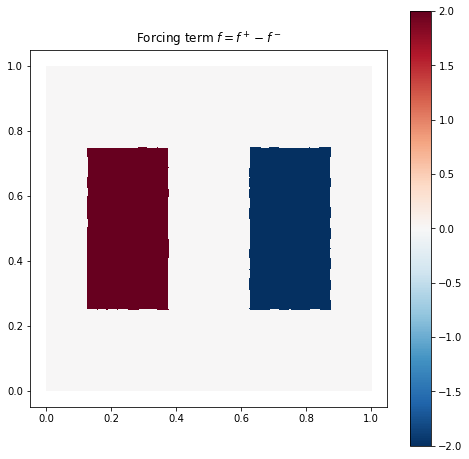

In [4]:
import matplotlib.tri as mtri
#
# plot forcing term
#
triang = mtri.Triangulation(coord.transpose()[0,:], coord.transpose()[1,:], topol)
fig1, ax1 = plt.subplots(figsize=(8, 8)); ax1.set_aspect('equal')
tpc = ax1.tripcolor(triang, forcing_cell , cmap='RdBu_r')
fig1.colorbar(tpc)
ax1.set_title('Forcing term $f=f^+-f^-$')
plt.show()


We load the controls from file. You can either change it in the file or change some controls in the next cell.

In [5]:
# init and set controls
ctrl = Dmkcontrols.DmkCtrl()
Dmkcontrols.get_from_file(ctrl,'dmk.ctrl')
ctrl.fn_tdens='tdens.dat'
ctrl.fn_pot='pot.dat'
ctrl.fn_statistics='dmk.log'


In [6]:
[info,opttdens,optpot,tolop_subgrid,coord_subgrid,timefun] = dmk_p1p0.solve_MinFluxProblem(topol,
                                                                                              coord,
                                                                                              forcing_cell,
                                                                                           pflux=1.0,
                                                                                              tolerance=1e-5,
                                                                                              ctrl=ctrl)
if (info==0): print('Convergence achieved')

Convergence achieved


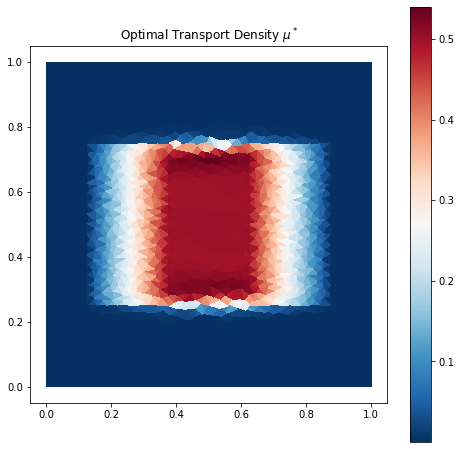

In [7]:
import matplotlib.tri as mtri
# plot forcing term
triang = mtri.Triangulation(coord.transpose()[0,:], coord.transpose()[1,:], topol)
fig1, ax1 = plt.subplots(figsize=(8, 8)); ax1.set_aspect('equal')
tpc = ax1.tripcolor(triang, opttdens , cmap='RdBu_r')
fig1.colorbar(tpc)
ax1.set_title('Optimal Transport Density $\mu^*$')
plt.show()

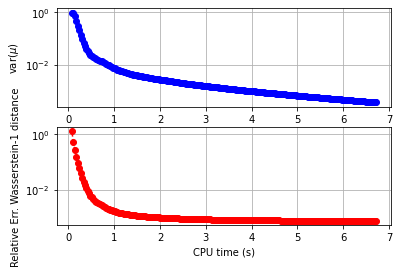

In [8]:
# plot convergence toward steady state
time      = np.array(timefun.time[0:timefun.last_time_iteration]);
cpu_time  = np.array(timefun.cpu_time[0:timefun.last_time_iteration])
var_tdens = np.array(timefun.var_tdens[1:timefun.last_time_iteration])
wass1     = np.array(timefun.lyapunov[1:timefun.last_time_iteration])
errwass1=(wass1[:]-exact_wass1)/(exact_wass1)

plt.figure(1)
plt.subplot(211)
plt.yscale('log')
plt.ylabel('var($\mu$)')
plt.xlabel('CPU time (s)')
plt.grid(True)
plt.plot(cpu_time[1:], var_tdens, 'bo--')

plt.subplot(212)
plt.yscale('log')
plt.ylabel('Relative Err. Wasserstein-1 distance')
plt.xlabel('CPU time (s)')
plt.grid(True)
plt.plot(cpu_time[1:], errwass1, 'ro--')
plt.show()